In [104]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# NFIRS incident type vs REAC score in NY by zipcode

In this notebook, we'll compare zipcodes with high and low average REAC scores, to see if they have different proportions of different incident types.

In [105]:
WORKING_DIR = 'D:/Fire Project/data/'

We'll load the most recent REAC scores for public and multifamily housing into DataFrames.

In [106]:
multifamily = pd.read_excel(WORKING_DIR + 'multifamily_physical_inspection_scores_0321.xlsx')
public = pd.read_excel(WORKING_DIR + 'public_housing_physical_inspection_scores_0321.xlsx')

Filter down to just NY properties for this initial exploration.

In [107]:
reac = pd.concat([public, multifamily])
reac = reac[reac.STATE_NAME == 'NY']
reac.sample()

,INSPECTION_ID,DEVELOPMENT_ID,DEVELOPMENT_NAME,ADDRESS,CITY,CBSA_NAME,CBSA_CODE,COUNTY_NAME,COUNTY_CODE,STATE_NAME,...,ZIPCODE,LATITUDE,LONGITUDE,LOCATION_QUALITY,PHA_CODE,PHA_NAME,INSPECTION_SCORE,INSPECTION_DATE,PROPERTY_ID,PROPERTY_NAME
445,570365,NY093001001,WEST AND ALDER COURTS,305 N 15th St,Olean,"Olean, NY Micropolitan Statistical Area",36460.0,Cattaraugus,9.0,NY,...,14760.0,42.082118,-78.448419,R,NY093,Olean Housing Authority,82,2016-06-13 08:43:06,NaN,NaN


In [108]:
reac.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1818 entries, 232 to 27411
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   INSPECTION_ID     1818 non-null   int64         
 1   DEVELOPMENT_ID    333 non-null    object        
 2   DEVELOPMENT_NAME  333 non-null    object        
 3   ADDRESS           1818 non-null   object        
 4   CITY              1818 non-null   object        
 5   CBSA_NAME         1772 non-null   object        
 6   CBSA_CODE         1818 non-null   float64       
 7   COUNTY_NAME       1818 non-null   object        
 8   COUNTY_CODE       1818 non-null   float64       
 9   STATE_NAME        1818 non-null   object        
 10  STATE_CODE        1818 non-null   float64       
 11  ZIPCODE           1818 non-null   float64       
 12  LATITUDE          1818 non-null   float64       
 13  LONGITUDE         1818 non-null   float64       
 14  LOCATION_QUALITY  181

Overall we have 1818 properties with 333 being public housing and the rest being multifamily.

Let's get the average REAC score for each zipcode. We'll rename the index and cast it to int for the sake of compatibility with the NFIRST values.

In [109]:
mean_scores = reac.groupby(by='ZIPCODE').INSPECTION_SCORE.mean()
mean_scores = mean_scores.rename_axis('zip')
mean_scores.index = mean_scores.index.astype(int)
mean_scores.sample()

zip
10460    80.285714
Name: INSPECTION_SCORE, dtype: float64

Now we'll get the NFIRST data so we can compare.

In [110]:
conn = sqlite3.Connection('fire_data.db')
inc_types = pd.read_sql("""
    WITH zips AS (
        SELECT ZIP5, INCIDENT_KEY 
        FROM incident_address
    )
    SELECT zips.ZIP5 as zip, INC_TYPE as inc_type, COUNT(*) as count
    FROM basic_incident bi JOIN zips
        ON bi.INCIDENT_KEY = zips.INCIDENT_KEY
    WHERE bi.STATE = 'NY'
    GROUP BY zips.ZIP5, bi.INC_TYPE
""", conn)

In [111]:
inc_types

,zip,inc_type,count
0,None,100,2
1,None,111,21
2,None,114,2
3,None,131,1
4,None,138,1
...,...,...,...
42351,Lawre,444,4
42352,Lawre,445,2
42353,Lawre,460,1
42354,NY,131,1


There are a few bad zipcode values like 'None' and 'NY'. Let's remove those.

In [112]:
valid_zip_mask = inc_types['zip'].astype(str).str.match(r'^\d{5}$')
inc_types = inc_types[valid_zip_mask]
inc_types

,zip,inc_type,count
457,10001,100,55
458,10001,111,70
459,10001,112,41
460,10001,113,299
461,10001,114,3
...,...,...,...
42324,99999,462,11
42325,99999,463,282
42326,99999,480,2
42327,99999,481,4


NY zipcodes only go up to about 15000, so we'll remove any bad zipcodes with higher values.

In [113]:
inc_types = inc_types[inc_types.zip < 15000]

We'll get the unique incident types that are represented in our data so that we can check each of them.

In [114]:
unique_types = inc_types.inc_type.unique()

Now we'll get the proportion of different incident types in each zipcode.

In [115]:
# Create a pivot table with 'zip' as the index, 'inc_type' as columns, and 'count' as values
pivot_table = pd.crosstab(index=inc_types['zip'], 
                          columns=inc_types['inc_type'], 
                          values=inc_types['count'], 
                          aggfunc='sum', 
                          margins=True)

# Replace NaN with 0
pivot_table.fillna(0, inplace=True)

# Calculate the total count for each zip code
total_count = pivot_table.loc[:, 'All'][:-1]

proportions_dict = {'zip': total_count.index}

for inc in unique_types:
    # Extract the count for the given inc_type
    sub_count = pivot_table.loc[:, inc][:-1]

    # Calculate the proportion of inc_type for each zip code
    proportion = sub_count / total_count

    # Add the proportions into the dict.
    proportions_dict[str(inc)] = proportion.values

The resulting dict, which we'll convert to a DataFrame, has the proportions of every incident type in every zipcode.

In [116]:
proportions_df = pd.DataFrame(proportions_dict)

Now we can merge together the two DataFrames to get REAC average score by zipcode side-by-side with the proportions of each inc_type by zipcode.

In [117]:
# Convert merge column type for compatability
proportions_df['zip'] = proportions_df['zip'].astype(str)
mean_scores.index = mean_scores.index.astype(str)

type_score = pd.merge(proportions_df, mean_scores, how='outer', on='zip')

Now that we have the proportions of incident types by zipcode, we look at the relationship between average REAC score (by zipcode) and proportion of incident type.

In [118]:
type_score.corr().INSPECTION_SCORE.sort_values().head(10)

445   -0.364993
412   -0.355079
113   -0.330806
117   -0.328430
151   -0.302582
118   -0.247618
112   -0.229223
116   -0.204050
134   -0.086998
461   -0.086194
Name: INSPECTION_SCORE, dtype: float64

In [119]:
type_score.corr().INSPECTION_SCORE.sort_values().tail(10)

441                 0.158717
150                 0.160177
463                 0.166372
631                 0.190558
114                 0.200622
444                 0.209490
440                 0.229982
411                 0.240425
111                 0.272317
INSPECTION_SCORE    1.000000
Name: INSPECTION_SCORE, dtype: float64

These incident codes are the most correlated with low average inspection scores (sorted strongest correlation to weakest):

- 445: Arcing, shorted electrical equipment
- 412: Gas leak (natural gas or LPG)
- 113: Cooking fire involving the contents of a cooking vessel without fire extension beyond the vessel
- 117: Commercial compactor fire, confined to contents of compactor
- 151: Outside rubbish, trash, or waste fire not included in 152–155
- 118: Trash or rubbish fire in a structure, with no flame damage to structure or its contents
- 112: Fire in structure, other than in a building
- 116: Fuel burner/boiler, delayed ignition or malfunction, where flames cause no damage outside the fire box
- 134: Water vehicle fire
- 461: Building or structure weakened or collapsed

And these incident codes are most correlated with high average inspections scores (sorted strongest correlation to weakest).

- 111: Building fire. Excludes confined fires (113–118)
- 411: Gasoline or other flammable liquid spill (flash point below 100 degrees F at standard temperature and pressure (Class I))
- 440: Electrical wiring/equipment problem, other
- 444: Power line down
- 114: Chimney or flue fire originating in and confined to a chimney or flue
- 631: Authorized controlled burning
- 463: Explosion, no fire, but with significant damage
- 150: Outside rubbish fire, other
- 441: Heat from short circuit (wiring), defective or worn insulation

One preliminary takeaway is that certain types of reported fire incidents, like gas leaks, cooking fires, indoor trash fires, and trash compactor fires are more commonly reported in zipcodes with poor REAC scores. 

On other hand, places with higher REAC scores report more general building fires, gasoline fires, and downed power lines.

In [120]:
pops = pd.read_csv(WORKING_DIR + 'DECENNIALSF12010.P1-Data.csv', skiprows=1)

pops['zipcode'] = pops['Geographic Area Name'].apply(lambda x: x.split(' ')[1])


In [121]:
pops = pd.read_csv(WORKING_DIR + 'DECENNIALSF12010.P1-Data.csv', skiprows=1)

# Split off the zipcode from the Geographic area name
pops['zipcode'] = pops['Geographic Area Name'].apply(lambda x: x.split(' ')[1])

# Get only the zip and population columns we need
pops = pops.loc[:, ['zipcode', 'Total']]

pops = pops.rename(columns={'zipcode': 'zip', 'Total': 'population'})

type_score_pop = pd.merge(type_score, pops, on='zip', how='inner')

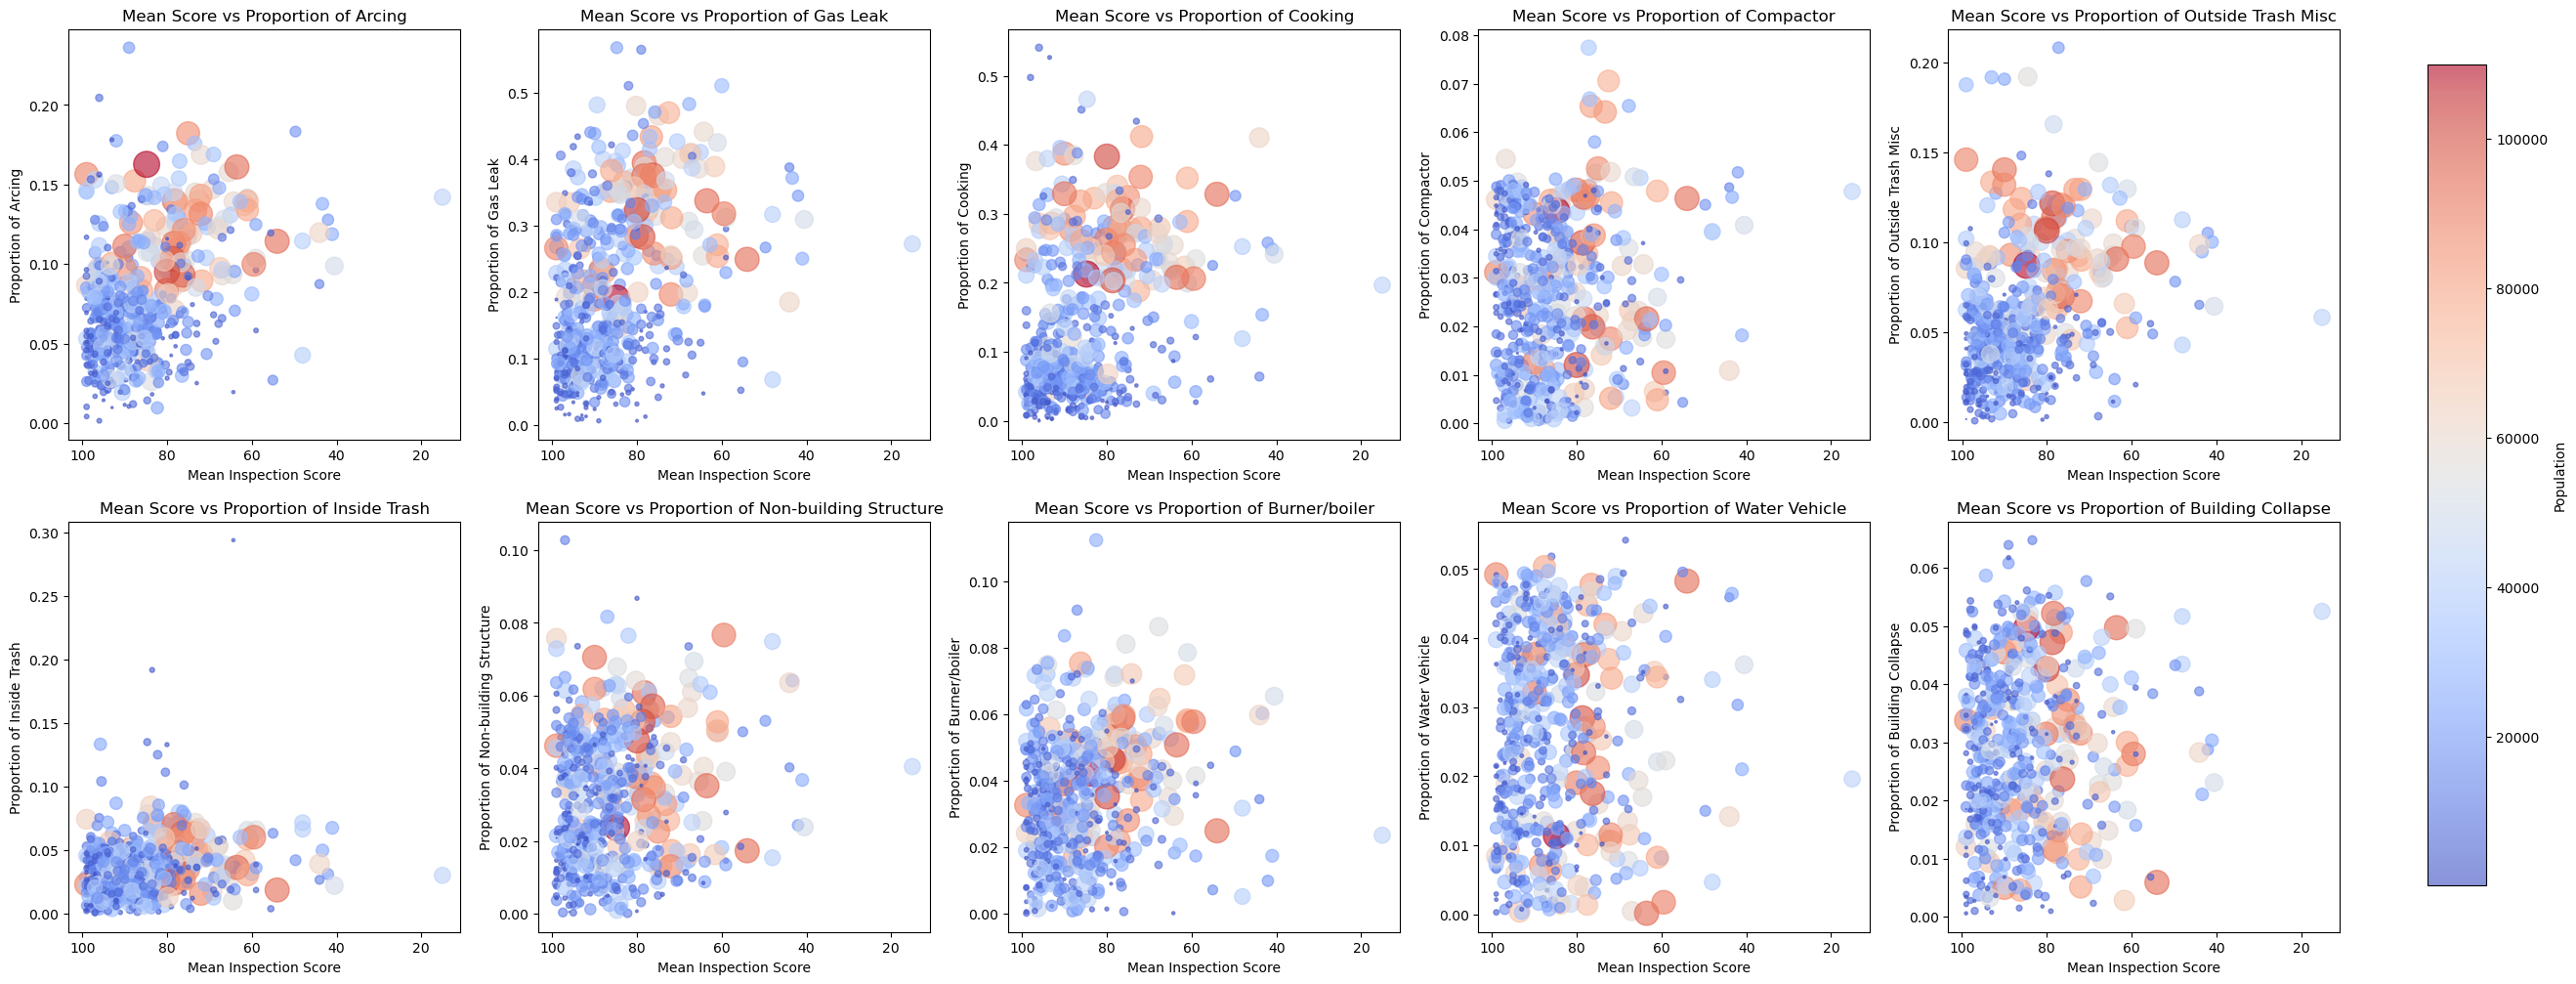

In [136]:
incs = [445, 412, 113, 117, 151, 118, 112, 116, 134, 461]
labels = ['Arcing', 'Gas Leak', 'Cooking', 'Compactor', 'Outside Trash Misc', 'Inside Trash', 'Non-building Structure', 'Burner/boiler', 'Water Vehicle', 'Building Collapse']
n_rows = 2
n_cols = 5

# Remove rows with NaN values in the 'INSPECTION_SCORE' column
df = type_score_pop.dropna(subset=['INSPECTION_SCORE'])

# Create the subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 12))
axes = axes.flatten()

for idx, inc in enumerate(incs):
    ax = axes[idx]
    
    # Use a color map based on 'population'
    cmap = plt.cm.get_cmap("coolwarm")
    norm = plt.Normalize(df['population'].min(), df['population'].max())

    # Add jitter to the x and y coordinates
    jitter_x = 0.05 * np.random.rand(len(df))
    jitter_y = 0.05 * np.random.rand(len(df))

    scatter = ax.scatter(df['INSPECTION_SCORE'] + jitter_x, df[str(inc)] + jitter_y,
                s=df['population'] / 300, c=df['population'], cmap=cmap, norm=norm, alpha=0.6)

    ax.set_xlabel('Mean Inspection Score')
    ax.set_ylabel(f'Proportion of {labels[idx]}')
    ax.set_title(f'Mean Score vs Proportion of {labels[idx]}')

    # Flip the x-axis
    ax.set_xlim(ax.get_xlim()[::-1])

# Add a colorbar
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
cbar = fig.colorbar(scatter, cax=cbar_ax)
cbar.set_label('Population')

# Show the plot
plt.show()


In [147]:
result = pd.read_sql("""
    WITH zips AS (
        SELECT ZIP5, INCIDENT_KEY 
        FROM incident_address
    )
    SELECT zips.ZIP5 as zip, ALARMS as alarms, COUNT(*) as count
    FROM basic_incident bi JOIN zips
        ON bi.INCIDENT_KEY = zips.INCIDENT_KEY
    WHERE bi.STATE = 'NY'
    GROUP BY zips.ZIP5, bi.ALARMS
""", conn)
result

,zip,alarms,count
0,None,None,32
1,None,1,2
2,0,None,201
3,0,0,75
4,0,1,43
...,...,...,...
4375,14 94,1,1
4376,1O6O6,None,1
4377,Cedar,1,22
4378,Lawre,1,53


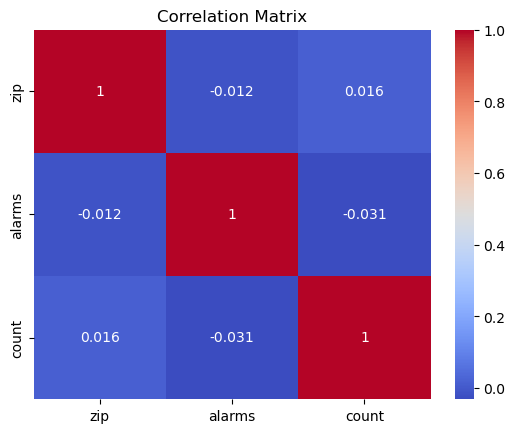

In [159]:
df = result.copy(deep=True)

# Convert non-numeric values to NaN
df['zip'] = pd.to_numeric(df['zip'], errors='coerce')
df['alarms'] = pd.to_numeric(df['alarms'], errors='coerce')

# Drop rows containing NaN values
df = df.dropna()

# Compute the correlation matrix
corr_matrix = df.corr()

# Plot the correlation matrix as a heatmap
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


In [157]:
pd.read_sql("""
    SELECT OTH_DEATH, COUNT(*)
    FROM basic_incident
    GROUP BY OTH_DEATH
""", conn)

,OTH_DEATH,COUNT(*)
0,NaN,13247822
1,0.0,38695
2,1.0,10088
3,2.0,1133
4,3.0,232
5,4.0,81
6,5.0,32
7,6.0,11
8,7.0,3
9,8.0,2
